In [1]:
import pubchempy as pcp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pubchempy'

In [2]:
properties = ["Molecularweight"]
smiles_list = ["C1=CC(=CC=C1C(=O)O)C(=O)O", "CCCCCCCCCC(=O)[O-].[Na+]"]

#pubchem に情報のない化合物はエラーとなるので、エラーが発生しても途中で終了させずに処理を継続できるようにtry文を使用
df = pd.DataFrame()
for smiles in smiles_list:
    try:
        temp = pcp.get_properties(properties, smiles, 'smiles', as_dataframe=True)
        #as_dataframe=True とすることでpandas dataframe として情報を取得可能
        temp['smiles'] = smiles
        df = pd.concat([df,temp], axis=0, join='outer',sort=True)
    except:
        pass
display("smiles-properties", df)

'smiles-properties'

,MolecularWeight,smiles
CID,,
7489,166.13,C1=CC(=CC=C1C(=O)O)C(=O)O
4457968,194.25,CCCCCCCCCC(=O)[O-].[Na+]


In [3]:
import torch

In [4]:
vocab_freq =  {}
word_length_dist = []
for smile in df["smiles"]:
    for s in smile:
        if s not in vocab_freq.keys():
            vocab_freq[s] = 0
        vocab_freq[s] += 1
    word_length_dist.append(len(smile))

vocab = list(vocab_freq.keys())

In [54]:
device = torch.device('cuda')

SMILES_MAXLEN = 50
LEARNING_RATE = 1e-3
NUM_EPOCHS = 500
BATCH_SIZE = 64
N_INPUT = len(vocab)*SMILES_MAXLEN
N_HIDDEN = 400
N_Z = 20

In [55]:
def smile2vec(vocab, vecsize, smile):
    vec = []
    for i in range(vecsize):
        v = [0 for _ in range(len(vocab))]
        if i < len(smile):
            v[vocab.index(smile[i])] = 1
        vec += v
    return vec

In [56]:
X = []
for smile in list(df["smiles"]):
    X.append(smile2vec(vocab, SMILES_MAXLEN, smile))
X = np.array(X)

In [57]:
T = list(df["MolecularWeight"])

In [58]:
T = np.array(T).reshape(len(T),1).astype(np.float32)

In [59]:
# 奇数番目のデータを教師データ、偶数番目のデータをテストデータとします。
index = np.arange(T.size)
X_train = X[index[index % 2 != 0], :] # 説明変数（教師データ）
X_test = X[index[index % 2 == 0], :] # 説明変数（テストデータ）
T_train = T[index[index % 2 != 0], :] # 目的変数（教師データ）
T_test = T[index[index % 2 == 0], :] # 目的変数（テストデータ）

In [60]:
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

T_train_tensor = torch.from_numpy(T_train).float()
T_test_tensor = torch.from_numpy(T_test).float()

In [61]:
from torch.utils.data import TensorDataset

train = TensorDataset(X_train_tensor, T_train_tensor)
test = TensorDataset(X_test_tensor, T_test_tensor)

In [62]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [63]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.from_numpy(X).float()
T_tensor = torch.from_numpy(T).float()

dataset = TensorDataset(X_tensor, T_tensor)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [64]:
class VAE(torch.nn.Module):
    def __init__(self, n_input=784, n_hidden=400, n_z=20):
        super(VAE, self).__init__()
        self.fc1 = torch.nn.Linear(n_input, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_z)
        self.fc3 = torch.nn.Linear(n_hidden, n_z)
        self.fc4 = torch.nn.Linear(n_z, n_hidden)
        self.fc5 = torch.nn.Linear(n_hidden, n_input)
        
    def encode(self, x):
        h = torch.nn.functional.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.nn.functional.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [65]:
from rdkit import Chem

def get_best_smile(out_tensor):
    best_smile = ""
    for vec in out_tensor:
        vec = vec.reshape(SMILES_MAXLEN, len(vocab))
        smile = "".join([vocab[torch.argmax(v).item()] for v in vec])
        mol = Chem.MolFromSmiles(smile)
        while not mol:
            if len(smile) == 0: break
            smile = smile[:-1]
            mol = Chem.MolFromSmiles(smile)
        
        if len(best_smile) < len(smile):
            best_smile = smile

    return best_smile

In [66]:
model = VAE(n_input=N_INPUT, n_hidden=N_HIDDEN, n_z=N_Z).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [67]:
model = VAE(n_input=N_INPUT, n_hidden=N_HIDDEN, n_z=N_Z).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [68]:
losses = []
reconst_losses = []
kl_divs = []
out_list = []
for epoch in range(NUM_EPOCHS):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, N_INPUT)
        x_reconst, mu, log_var = model(x)
        
        reconst_loss = torch.nn.functional.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        reconst_losses.append(reconst_loss.item())
        kl_divs.append(kl_div.item())
        
        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, NUM_EPOCHS, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        z = torch.randn(BATCH_SIZE, N_Z).to(device)
        out = model.decode(z)
        print("Epoch[{}/{}], Generated SMILES: {}".format(epoch+1, NUM_EPOCHS, get_best_smile(out)))
        
        out_list.append(get_best_smile(out))
        # out, _, _ = model(x)
        # print("Epoch[{}/{}], Reconstructed SMILES: {}".format(epoch+1, NUM_EPOCHS, get_best_smile(out)))

Epoch[1/500], Generated SMILES: N-NN
Epoch[2/500], Generated SMILES: C1ON1
Epoch[3/500], Generated SMILES: C1ON1
Epoch[4/500], Generated SMILES: C1NCC(=C.CC1C)
Epoch[5/500], Generated SMILES: C1NCCC=CCN1
Epoch[6/500], Generated SMILES: CCCCCCNCCC(=O)
Epoch[7/500], Generated SMILES: CCCCCCCCCC(=O)[O-].CN
Epoch[8/500], Generated SMILES: C1CCC(=CC=C1C(=O)O)C
Epoch[9/500], Generated SMILES: C1=CC(=CC=C1C(=O)O)C
Epoch[10/500], Generated SMILES: CCCCCCCCCC(=O)[O-]
Epoch[11/500], Generated SMILES: C1CCC(=CC=C1C(=O)O)C(=O)O
Epoch[12/500], Generated SMILES: C1=CC(=CC=C1C(=O)O)C(=O)O
Epoch[13/500], Generated SMILES: CCCCCCCCCC(=O)[O-].[Na+]
Epoch[14/500], Generated SMILES: CCCCCCCCCC(=O)[O-].[Na+]
Epoch[15/500], Generated SMILES: C1=CC(=CC=C1C(=O)O)C(=O)OCO
Epoch[16/500], Generated SMILES: C1CCC(=CC=C1C(=O)O)C(=O)O
Epoch[17/500], Generated SMILES: CCCCCCCCCC(=O)[O-].[Na+]
Epoch[18/500], Generated SMILES: C1=CC(=CC=C1C(=O)O)C(=O)O
Epoch[19/500], Generated SMILES: C1=CC(=CC=C1C(=O)O)C(=O)O
Epoch[2

In [69]:
out_list

['N-NN',
 'C1ON1',
 'C1ON1',
 'C1NCC(=C.CC1C)',
 'C1NCCC=CCN1',
 'CCCCCCNCCC(=O)',
 'CCCCCCCCCC(=O)[O-].CN',
 'C1CCC(=CC=C1C(=O)O)C',
 'C1=CC(=CC=C1C(=O)O)C',
 'CCCCCCCCCC(=O)[O-]',
 'C1CCC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'CCCCCCCCCC(=O)[O-].[Na+]',
 'CCCCCCCCCC(=O)[O-].[Na+]',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1CCC(=CC=C1C(=O)O)C(=O)O',
 'CCCCCCCCCC(=O)[O-].[Na+]',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CC=C1C(=O)O)C(=O)O-O',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CCCC1C(=O)O)C(=O)OC',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1=CC(=CC=C1C(=O)O)C(=O)OOON',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCON.C',
 'C1=CC(=CC=C1C(=O)O)C(=O)OC',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCONCC',
 'C1=CC(=CC=C1C(=O)O)C(=O)O-O',
 'C1=CC(=CC=C1C(=O)O)C(=O)O.N',
 'C1=CC(=CC=C1C(=O)O)C(=O)O-O',
 'C1=C

In [84]:
df_search = pd.DataFrame()
for smiles in out_list:
    try:
        temp = pcp.get_properties(properties, smiles, 'smiles', as_dataframe=True)
        #as_dataframe=True とすることでpandas dataframe として情報を取得可能
        temp['smiles'] = smiles
        df_search = pd.concat([df_search,temp], axis=0, join='outer',sort=True)
    except:
        pass

In [100]:
df_vae_search = df_search.dropna()
df_vae_search.to_csv("vae_search.csv")
display(df_vae_search)

,MolecularWeight,smiles
CID,,
446953,47.060,N-NN
15817734,45.041,C1ON1
15817734,45.041,C1ON1
11062339,113.20,C1NCC(=C.CC1C)
88748612,157.25,CCCCCCNCCC(=O)
...,...,...
54367917,196.16,C1=CC(=CC=C1C(=O)O)C(=O)OCO
68427920,184.15,C1=CC(=CC=C1C(=O)O)C(=O)O.O
12813457,182.13,C1=CC(=CC=C1C(=O)O)C(=O)O-O


In [106]:
vae_search_index = pd.DataFrame(df_vae_search.index)
vae_search_index.to_csv("vae_search.csv", header=False, index=False)

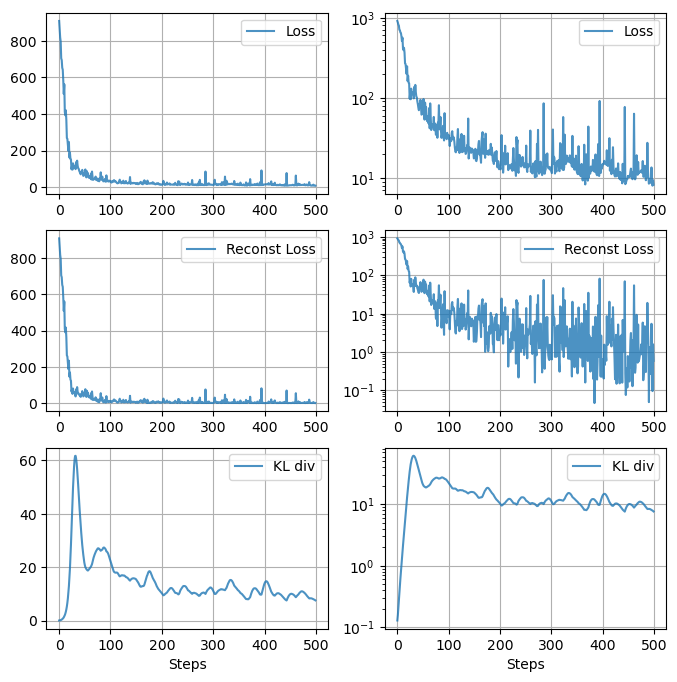

In [103]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,8))
plot_data = [losses, reconst_losses, kl_divs]
legends = ["Loss", "Reconst Loss", "KL div"]
for i in range(3):
    axes[i][0].plot(plot_data[i], label=legends[i], alpha=0.8)
    axes[i][0].grid()
    axes[i][0].legend()
    axes[i][1].plot(plot_data[i], label=legends[i], alpha=0.8)
    axes[i][1].grid()
    axes[i][1].legend()
    axes[i][1].set_yscale('log')
axes[2][0].set_xlabel("Steps")
axes[2][1].set_xlabel("Steps")
plt.show()

In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LEARNING_RATE = 1e-6
NUM_EPOCHS = 30000
BATCH_SIZE = 256
N_INPUT = len(vocab)*SMILES_MAXLEN
N_HIDDEN = 100
N_LATENT = 100

In [114]:
G = torch.nn.Sequential(
    torch.nn.Linear(N_LATENT, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_INPUT),
    torch.nn.Tanh())

G = G.to(device)

In [115]:
D = torch.nn.Sequential(
    torch.nn.Linear(N_INPUT, N_HIDDEN),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(N_HIDDEN, 1),
    torch.nn.Sigmoid())

D = D.to(device)

In [116]:
criterion = torch.nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE)
g_optimizer = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE)

In [117]:
d_losses = []
g_losses = []
real_scores = []
fake_scores = []

total_step = len(data_loader)
for epoch in range(NUM_EPOCHS):
    for i, (data, _) in enumerate(data_loader):

        # 判別器の学習
        outputs = D(data.to(device))
        real_labels = torch.ones(outputs.shape[0], 1).to(device)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        z = torch.randn(BATCH_SIZE, N_LATENT).to(device)
        fake_data = G(z)
        outputs = D(fake_data)
        fake_labels = torch.zeros(outputs.shape[0], 1).to(device)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        if (i%2) == 0:
            d_loss.backward()
        d_optimizer.step()
        
        # 生成器の学習
        z = torch.randn(BATCH_SIZE, N_LATENT).to(device)
        fake_data = G(z)
        outputs = D(fake_data)
        
        real_labels = torch.ones(outputs.shape[0], 1).to(device)
        g_loss = criterion(outputs, real_labels)
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        # 結果の記録
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        real_scores.append(real_score.mean().item())
        fake_scores.append(fake_score.mean().item())
        if (i+1) % 100 == 0 and (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.4f}, D(G(z)): {:.4f}' 
                  .format(epoch, NUM_EPOCHS, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    if (epoch+1) % 100 == 0:
        print("Epoch[{}/{}], Generated SMILES: {}".format(
            epoch+1, NUM_EPOCHS, get_best_smile(fake_data)))
        out_list.append(get_best_smile(fake_data))

Epoch[100/30000], Generated SMILES: N-N
Epoch[200/30000], Generated SMILES: CC
Epoch[300/30000], Generated SMILES: C[C]
Epoch[400/30000], Generated SMILES: C[C]
Epoch[500/30000], Generated SMILES: NCN
Epoch[600/30000], Generated SMILES: CC
Epoch[700/30000], Generated SMILES: C
Epoch[800/30000], Generated SMILES: N-C
Epoch[900/30000], Generated SMILES: C[C]
Epoch[1000/30000], Generated SMILES: CC
Epoch[1100/30000], Generated SMILES: C
Epoch[1200/30000], Generated SMILES: CCO
Epoch[1300/30000], Generated SMILES: CC
Epoch[1400/30000], Generated SMILES: CCC
Epoch[1500/30000], Generated SMILES: CNN
Epoch[1600/30000], Generated SMILES: [1C++]
Epoch[1700/30000], Generated SMILES: CCC
Epoch[1800/30000], Generated SMILES: CC
Epoch[1900/30000], Generated SMILES: C-C
Epoch[2000/30000], Generated SMILES: C[Ca]
Epoch[2100/30000], Generated SMILES: C=O
Epoch[2200/30000], Generated SMILES: C-C
Epoch[2300/30000], Generated SMILES: CC
Epoch[2400/30000], Generated SMILES: C-C
Epoch[2500/30000], Generate

In [120]:
out_list

['N-NN',
 'C1ON1',
 'C1ON1',
 'C1NCC(=C.CC1C)',
 'C1NCCC=CCN1',
 'CCCCCCNCCC(=O)',
 'CCCCCCCCCC(=O)[O-].CN',
 'C1CCC(=CC=C1C(=O)O)C',
 'C1=CC(=CC=C1C(=O)O)C',
 'CCCCCCCCCC(=O)[O-]',
 'C1CCC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'CCCCCCCCCC(=O)[O-].[Na+]',
 'CCCCCCCCCC(=O)[O-].[Na+]',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1CCC(=CC=C1C(=O)O)C(=O)O',
 'CCCCCCCCCC(=O)[O-].[Na+]',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CC=C1C(=O)O)C(=O)O-O',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'C1=CC(=CCCC1C(=O)O)C(=O)OC',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCO',
 'C1=CC(=CC=C1C(=O)O)C(=O)OOON',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCON.C',
 'C1=CC(=CC=C1C(=O)O)C(=O)OC',
 'C1=CC(=CC=C1C(=O)O)C(=O)OCONCC',
 'C1=CC(=CC=C1C(=O)O)C(=O)O-O',
 'C1=CC(=CC=C1C(=O)O)C(=O)O.N',
 'C1=CC(=CC=C1C(=O)O)C(=O)O-O',
 'C1=C

In [118]:
for smiles in out_list:
    try:
        temp = pcp.get_properties(properties, smiles, 'smiles', as_dataframe=True)
        #as_dataframe=True とすることでpandas dataframe として情報を取得可能
        temp['smiles'] = smiles
        df_search = pd.concat([df_search,temp], axis=0, join='outer',sort=True)
    except:
        pass

In [121]:
df_GAN_search = df_search.loc[:, "smiles"].dropna()
df_GAN_search.to_csv("GAN_search.csv", index=False, header=False)
display(df_GAN_search)

CID
446953                             N-NN
15817734                          C1ON1
15817734                          C1ON1
11062339                 C1NCC(=C.CC1C)
0                           C1NCCC=CCN1
                       ...             
0           C1=CC(CCCC(=O)[O-].[Na+])1C
0              CC=CC(CCC=C=O)[O-].[Na+]
0                    CC=CC(CCCCC=O)[O-]
0              CC=CC(=CC=C=O)[O-].[Na+]
0              CC=CC(CCC=C=C)[O-].[Na+]
Name: smiles, Length: 1319, dtype: object

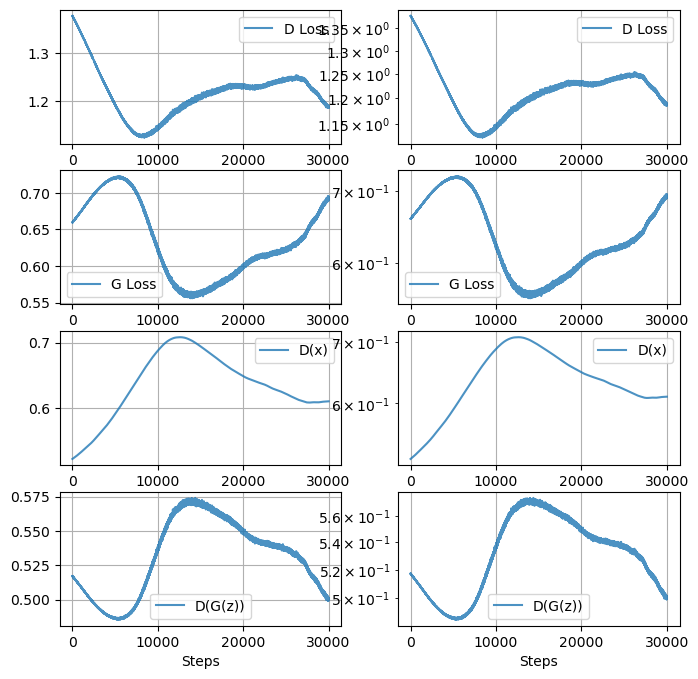

In [52]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8,8))
plot_data = [d_losses, g_losses, real_scores, fake_scores]
legends = ["D Loss", "G Loss", "D(x)", "D(G(z))"]
for i in range(4):
    axes[i][0].plot(plot_data[i], label=legends[i], alpha=0.8)
    axes[i][0].grid()
    axes[i][0].legend()
    axes[i][1].plot(plot_data[i], label=legends[i], alpha=0.8)
    axes[i][1].grid()
    axes[i][1].legend()
    axes[i][1].set_yscale('log')
axes[3][0].set_xlabel("Steps")
axes[3][1].set_xlabel("Steps")
plt.show()